## Training CNN on CIFAR10 Dataset [1]Â¶

In [1]:
#a Tensor library with GPU support
import torch

#Datasets, Transforms and Models specific to Computer Vision
import torchvision
import torchvision.transforms as transforms

#differentiation library that supports all differentiable Tensor operations in torch
from torch.autograd import Variable

#a neural networks library integrated with autograd functionality
import torch.nn as nn
import torch.nn.functional as F

#an optimization package with standard optimization methods such as SGD, RMSProp, LBFGS, Adam etc.
import torch.optim as optim

#scientific computing library for Python
import numpy as np

#plotting and visualization library
import matplotlib.pyplot as plt
#Display on the notebook
%matplotlib inline 
plt.ion() #Turn interactive mode on.

In [2]:
####train data
#Compose transforms (applies data transformation and augmentation) prior to feeding to training
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#inbuilt dataset class for reading CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='../data/imgFolders', train=True,
                                        download=False, transform=transform)

#dataloader for Batching, shuffling and loading data in parallel
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

####test data
testset = torchvision.datasets.CIFAR10(root='../data/imgFolders', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

('GroundTruth: ', '  cat  ship  ship plane')


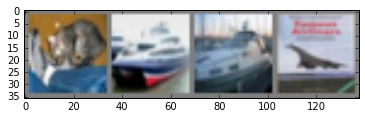

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
class Net(nn.Module):
    
    #define the learnable paramters by calling the respective modules (nn.Conv2d, nn.MaxPool2d etc.)
    def __init__(self):
        super(Net, self).__init__()
        
        #calling conv2d module for convolution
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5,stride=1,padding=0,bias=True)
        
        #calling MaxPool2d module for max pooling with downsampling of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        #fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    #defining the structure of the network
    def forward(self, x):
        
        #Applying relu activation after each conv layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        #reshaping to 1d for giving input to fully connected units
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

#Printing the network architecture
print(net)

Net (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


In [5]:
#Printing the parameter values
params = list(net.parameters())
print(params[0].size())  # conv1's .weight

torch.Size([6, 3, 5, 5])


In [6]:
input = Variable(torch.randn(1, 3, 32, 32))
out = net(input)
print(out)

Variable containing:
 0.1642 -0.0209 -0.1107 -0.0825  0.1350 -0.1052  0.0364 -0.1414 -0.1520  0.0497
[torch.FloatTensor of size 1x10]



In [7]:
net.zero_grad()
out.backward(torch.randn(1, 10))

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

[1,  2000] loss: 2.178
[1,  4000] loss: 1.849
[1,  6000] loss: 1.691
[1,  8000] loss: 1.613
[1, 10000] loss: 1.518
[1, 12000] loss: 1.483


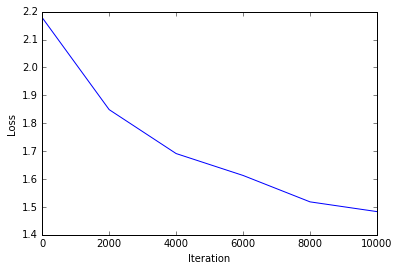

Finished Training


In [9]:
plotIter = 2000
plotIterCntr = 0
numEpochs = 1
trainLoss = np.zeros((plotIter*numEpochs,1))
trainIter = np.arange(plotIter*numEpochs)

#Transferring the model to GPU
#net.cuda()

for epoch in range(numEpochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        #inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % plotIter == plotIter-1:    # print every plotIter mini-batches
            trainLoss[plotIterCntr] = running_loss / plotIter
            plotIterCntr+=1
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / plotIter))
            running_loss = 0.0
 
#Plotting the training graph
plt.plot(np.arange(plotIterCntr)*plotIter,trainLoss[0:plotIterCntr], label="train")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

print('Finished Training')

In [10]:
#outputs = net(Variable(images).cuda())
outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

('Predicted: ', '  cat  ship truck  ship')


In [11]:
## Prediction of accuracy
correct = 0
total = 0

#Iterating over the batches returned from testloader
for data in testloader:
    images, labels = data
    #outputs = net(Variable(images.cuda()))
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    #labels = labels.cuda()
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %


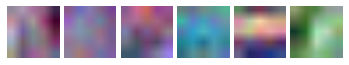

In [12]:
#### Visualization of Layer 1 weights
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
net_cpu = net.cpu()

#Reading the conv1 weights
dat = net_cpu.conv1.weight.data.numpy()

#Normalizing the weights from (0,1)
maxVal = dat.max()
minVal = abs(dat.min())
maxVal = max(maxVal,minVal)
dat = dat / maxVal
dat = dat / 2
dat = dat + 0.5

#calling visualization function
plot_kernels(dat.transpose((0,2,3,1)))

In [13]:
class Net_DB(nn.Module):
    def __init__(self):
        super(Net_DB, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        #applying batch normalization
        self.conv1_bn = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        #Flag to apply droputs only at training
        self.is_training = False

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(self.conv1_bn(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        
        #Applying dropouts
        x = F.dropout(x, p=0.2, training=self.is_training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_db = Net_DB()

[1,  2000] loss: 2.132
[1,  4000] loss: 1.848
[1,  6000] loss: 1.704
[1,  8000] loss: 1.625
[1, 10000] loss: 1.542
[1, 12000] loss: 1.508


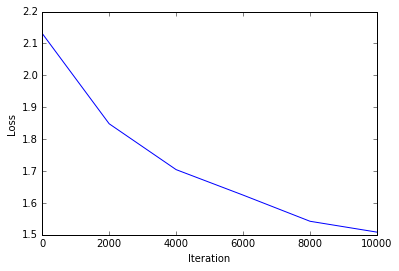

Finished Training with droputs and batch normalization


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_db.parameters(), lr=0.001, momentum=0.9)

plotIter = 2000
plotIterCntr = 0
numEpochs = 1
trainLoss = np.zeros((plotIter*numEpochs,1))
trainIter = np.arange(plotIter*numEpochs)

#net_db.cuda()
net_db.is_training = True

for epoch in range(numEpochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        #inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_db(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % plotIter == plotIter-1:    # print every plotIter mini-batches
            trainLoss[plotIterCntr] = running_loss / plotIter
            plotIterCntr+=1
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / plotIter))
            running_loss = 0.0
            
plt.plot(np.arange(plotIterCntr)*plotIter,trainLoss[0:plotIterCntr], label="train")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

print('Finished Training with droputs and batch normalization')

In [ ]:
net_db.is_training = False

## Prediction of accuracy
correct = 0
total = 0

for data in testloader:
    images, labels = data
    #outputs = net_db(Variable(images.cuda()))
    outputs = net_db(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    #labels = labels.cuda()
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))